In [1]:
%cd /data/codes/apa/train/

import pandas as pd
import os
from glob import glob
import json
from pandarallel import pandarallel
import random
import re

pandarallel.initialize(nb_workers=10, progress_bar=True)

/data/codes/apa/train
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/10"
# audio_dir = "/data/audio_data/prep_submission_audio/10"
# metadata_path="/data/audio_data/pronunciation_scoring_result/dataset/info_qt_10_trainset.csv"

json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/12"
audio_dir = "/data/audio_data/prep_submission_audio/12"
metadata_path="/data/codes/pronunciation-scoring-evaluate/data/raw/train-data-type-12-v2.csv"

metadata = pd.read_csv(metadata_path)
print(metadata.shape)
metadata = metadata[metadata.total_time > 1.0]
print(metadata.shape)
metadata.head(2)

(148959, 13)
(148959, 13)


,Unnamed: 0,id,is_deleted,user_id,question_id,question_type,question_content,url,score,fidelity_class,created_at,total_time,word_count
0,530923,5107058,0,187868.0,16681,12,Depressed,https://storage.googleapis.com/materials-eleme...,59.0,RELEVANT,2023-08-31 16:27:58,2.71,1.0
1,705508,1590011,0,59129.0,16681,12,Depressed,https://storage.googleapis.com/materials-eleme...,87.0,RELEVANT,2022-10-05 16:06:55,1.69,1.0


<Axes: >

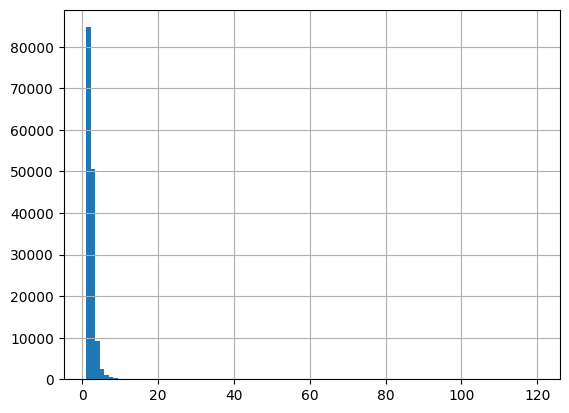

In [3]:
metadata.total_time.hist(bins=100)

In [4]:
import torchaudio

def is_valid(audio_id):
    abs_path = os.path.join(audio_dir, f'{audio_id}.wav')
    if not os.path.exists(abs_path):
        return False
    try:
        wav, sr = torchaudio.load(abs_path)
        if sr != 16000:
            return False
    except:
        return False
    
    return True

is_exist =  metadata.id.parallel_apply(is_valid)
print(metadata.shape)
metadata = metadata[is_exist]
print(metadata.shape)

(148959, 13)
(148917, 13)


In [5]:
lexicon_path = "/data/codes/prep_ps_pykaldi_dev/resources/lexicon_libri.txt"
vocab = pd.read_csv(lexicon_path, sep="\t", names=["word", "arpa"])
lexicon = {}
for name, group in vocab.groupby("word"):
    lexicon[name] = group["arpa"].tolist()

In [6]:
decision2color = {
    "correct": 2,
    "warning":1,
    "error":0
}

In [7]:
def norm_text(text):
    text = re.sub(r"[\,\.\!\?\:\;]", " ", text)
    text = re.sub("\s+", " ", text).strip()
    text = text.upper()

    return text

def is_valid_phoneme(phoneme):
    if phoneme["phoneme_error_arpabet"] != "normal":
        trans = phoneme["phoneme_error_arpabet"].split(" - ")[-1]
        labels = phoneme["phoneme_error_arpabet"].split(" - ")[0]
        if len(labels.split(" ")) >= 2:
            return False
        
        if len(trans.split(" ")) >= 2:
            return False
        
        # if labels in trans:
        #     return False
        
    return True
            
def parse_metadata_data(json_path):
    try: 
        with open(json_path, "r") as f:
            content = json.load(f)
        id = os.path.basename(json_path).split(".")[0]

        utterances = []
        for raw_utterance in content["utterance"]:
            utterance = {
                "id": id,
                "raw": raw_utterance["sentence"],
                "text": None,
                "utt_id": None,
                "start_time": None,
                "end_time": None,
                "arpas": [],
                "trans": [],
                "phone_scores": [],
                "word_scores": [],
                "decisions": [],
                "word_ids": [],
                "utterance_scores": raw_utterance["nativeness_score"],
            }
            ignore = False
            words = []
            for word_id, word in enumerate(raw_utterance["words"]):
                if norm_text(word["text"]) not in lexicon:
                    ignore = True
                    break

                if word["trans_arpabet"] not in lexicon[norm_text(word["text"])]:
                    ignore = True
                    break

                if len(word["phonemes"]) != len(word["trans_arpabet"].split()):
                    ignore = True
                    break
                
                utterance["arpas"] += word["trans_arpabet"].split()
                
                for phoneme in word["phonemes"]:
                    if not is_valid_phoneme(phoneme):
                        ignore = True
                        break
                    arpa = phoneme["trans_arpabet"]
                    decision = decision2color[phoneme["decision"]]
                    score = phoneme["nativeness_score"] if phoneme["nativeness_score"] >= 0 else 0
                    tran = phoneme["trans_arpabet"]

                    # utterance["arpas"].append(arpa)
                    utterance["phone_scores"].append(score)
                    utterance["word_ids"].append(word_id)
                    utterance["trans"].append(tran)
                    utterance["decisions"].append(decision)

                word_score = word["nativeness_score"]
                words.append(norm_text(word["text"]))
                utterance["word_scores"].append(word_score)
            
            utterance["text"] = " ".join(words)

            if ignore == False:
                utterances.append(utterance)
        
        return utterances
    except:
        return []

extracted_data = metadata.id.parallel_apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))
extracted_data.head()
# metadata.id.head(100).apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))

0    [{'id': '5107058', 'raw': 'Depressed', 'text':...
1    [{'id': '1590011', 'raw': 'Depressed', 'text':...
2    [{'id': '1951102', 'raw': 'Depressed', 'text':...
3    [{'id': '5130816', 'raw': 'Depressed', 'text':...
4    [{'id': '1689656', 'raw': 'Depressed', 'text':...
Name: id, dtype: object

In [8]:
data = extracted_data.explode().reset_index()["id"]
data = pd.DataFrame({"data": data})
print(data.shape)
data.dropna(inplace=True)
data["text"] = data["data"].apply(lambda x: x["text"])
# data.drop_duplicates("text", inplace=True)
data = data.reset_index()[["data"]]
print(data.shape)
data.head()

(148917, 1)
(133407, 1)


,data
0,"{'id': '5107058', 'raw': 'Depressed', 'text': ..."
1,"{'id': '1590011', 'raw': 'Depressed', 'text': ..."
2,"{'id': '1951102', 'raw': 'Depressed', 'text': ..."
3,"{'id': '5130816', 'raw': 'Depressed', 'text': ..."
4,"{'id': '1689656', 'raw': 'Depressed', 'text': ..."


<Axes: >

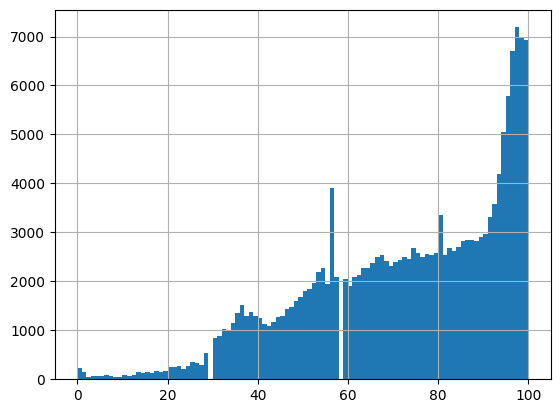

In [9]:
scores = data["data"].apply(lambda x: x["word_scores"]).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

(239244, 1)


<Axes: >

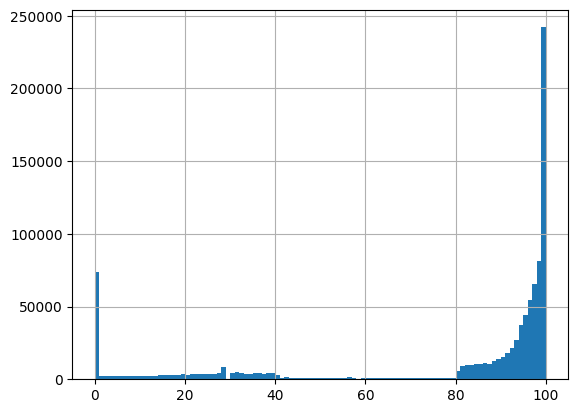

In [10]:
scores = data["data"].apply(lambda x: x["phone_scores"]).to_list()
scores = [score for sample in scores for score in sample]

scores = pd.DataFrame(scores, columns=["score"])
print(scores[scores.score<80].shape)
scores.score.hist(bins=100)

In [11]:
import numpy as np

def check_valid(score, threshold=0.35, score_threshold=80):
    score = np.array(score)

    is_low_score = score < score_threshold

    rate = score[is_low_score].shape[0] / (score[is_low_score].shape[0] + score[~is_low_score].shape[0])
    if rate > threshold:
        return True
    
    if random.randint(0, 100) >= 0:
        return True
    
    return False

is_valid = data["data"].apply(lambda x: check_valid(x["phone_scores"]))
print(data[is_valid].shape)
print(data[~is_valid].shape)

(133407, 1)
(0, 1)


<Axes: >

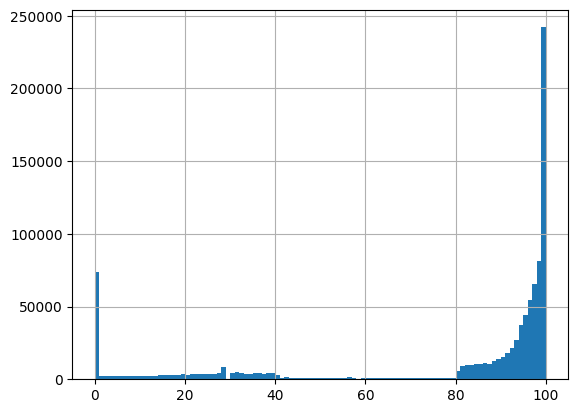

In [12]:
scores = data[is_valid]["data"].apply(lambda x: x["phone_scores"]).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

In [13]:
from tqdm import tqdm
 
extracted_data = data[is_valid]
path = "prep_data/raw_jsonl/train-data-type-12-v2.jsonl"
with open(path, "w", encoding="utf-8") as f:
    for index in tqdm(extracted_data.index):
        sample = extracted_data.loc[index, "data"]
        json_obj = json.dumps(sample)

        f.write(f'{json_obj}\n')

100%|██████████| 133407/133407 [00:00<00:00, 141462.46it/s]
